<a href="https://colab.research.google.com/github/JuanDaGue/Seminario/blob/main/2_Modelo_(Bs)_F%C3%ADsicamente_motivado_(Emcee)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 45 kB 1.6 MB/s 


In [ ]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import seaborn as sns
import corner
import pymc3 as pm
import arviz as az

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving figure1_plotdata.csv to figure1_plotdata.csv


# Discrepacias ok sigma fijo 

Como en ,los modelos de Bowman para la Temperatura de primer plano, encontrabamos unos coeficientes que no tenian mucho significado fisico, para estos modelos, vamos a tomar una funcion $T_F(\nu)$ que sea los mas fiel posible a la temperatura del foreground que observariamos desde la tierra, por esto tomamos la ecuacion  $11$ de [Concerns about modelling of the EDGES data](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-018-0796-5/MediaObjects/41586_2018_796_MOESM1_ESM.pdf) por tanto la función $T_F$ ahora posee otros parametos $(ds)$, los cuales tienen un significado mas fisico, entre ellos esta la opacidad del medio $d_3$, y la tempera de la ionosfera $T_e$ y alpha que es....

La Consersion entre los parametros usados en los modelos anteriores y esta son:

$a_0 = b_0$, $a_1 = b_0b_1$, $a_2 = b_0(b_1^2/2 + b_2)$,$a_3 = −b_0b_3$ y $a_4=b_4$

Hay que tener en cuenta que $b_3$ es la opacidad de la ionosfera, por lo cual debe ser mayor a cero, para que exista absorción y no amplificación.


$\alpha$ para puede ser n valor que oscila entre 2.4 a 2.7

In [ ]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

In [ ]:
Col=['b','r','darkorange','darkmagenta','gold','g','khaki','r','indigo','teal']
Cons_names=np.array(['Bow','Pyemcee','Pyemcee2','Natu_result','Intento','Natu'])


##funciones

In [ ]:
"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf

def T_fb(v,b0,b1,b2,b3,b4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return b0*(v/vc)**(-2.5+b1+b2*np.log(v/vc))*np.e**(-b3*(v/vc)**-2.0)+b4*(v/vc)**(-2.0)


In [ ]:
def T_modelo(x,y,yerr,const):
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma= const             # intersección con el eje y
  nll=lambda *args: -log_likelihood(*args) # Construccion de la funcion lamda 
  v=x
  N=len(x) 
  vc=78.0
  #Condiciones iniciales
  In=np.array([a0,a1,a2,a3,a4,A,v0,w,tau]) + 0.1 * np.random.randn(9)
  #Solución
  Sol=minimize(nll,In,args=(x, y, yerr))
  # Extrayendo los valores de los parametros arojados por MlE
  popt = Sol.x
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt

  return popt

def nwlakers(x,y,yerr,Sol,N,walkers,steps,i):
  pos = Sol+ 10e-2* np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr,i))
  sampler.run_mcmc(pos, steps, progress=True);
  
  #parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return sampler

def log_likelihood(theta,x,y,yerr):
  v=x
  sigma=yerr
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
def log_probability(theta, x, y, yerr,i):
    lp = log_p(theta,i,Cons_names)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
def log_p (theta,i,Cons_names):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta

  if Cons_names[i]== 'Bow':
    if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0: 
      return 0.0
  return -np.inf 

In [ ]:
def discg(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//10 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=abs(np.mean(params[:,9]))
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
    return discs,disco


Rejection rate = 0 %


In [ ]:
def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//10 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=0.02
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      plt.xlabel("Observed Discrepancies")
      plt.xlabel("Simulated Discrepancies")

      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

## Datos

In [ ]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables

x_C,y_C=Dat[:,0][Dat[:,0]>60.0] ,Dat[:,2][Dat[:,0]>60.0] # Variables
x_C,y_C=x_C[x_C<94.0],y_C[x_C<94.0]

Constante=np.zeros((6,9))
yerr=0.13


In [ ]:
Sol=Sol_forz=np.array([1755, -0.08 ,-0.012,0.0052,1100,0.5,78.3,18.9,7.5])# Profe
Sol=Sol_forz=np.array([1750.88, -0.067 ,-0.078,0.00006,394,0.5,78.3,18.6,4.5])
yerr=0.015

def T_f(v,b0,b1,b2,b3,Te):
  vc=75.0 # frecuancia central (rean) 
  return (b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0)+Te*(1-np.exp(-b3*(v/vc)**-2.0))

def log_like(theta,x,y,sigma):
  v=x
  b0,b1,b2,b3,Te,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,b0,b1,b2,b3,Te,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
def log_prob(theta, x, y):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x, y,0.24)
def log_p(theta):
  b0,b1,b2,b3,Te,A,v0,w,tau = theta
  if 1700 < b0 < 1800.0 and -0.070 < b1 < -0.007 and  -2.1< b2 < -0.00011 and 0.0000 <b3 < 0.2 and 200 < Te < 2000 and 0.170 < A <8.5 and  76.8< v0 <79.0 and 18.5 <w < 22.0 and 1.0 <tau< 10.0:
  #if 1740 < b0 < 1760.0 and -0.1 < b1 < -0.07 and  -0.1< b2 < 0.11 and 0.00010 <b3 < 0.2 and 100 < Te < 1500 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 21.0 and 4.5 <tau< 8.0:
  #if 1700 < b0 < 1760.0 and -0.9 < b1 < 0.07 and  -0.9< b2 < 0.11 and 0.000010 <b3 < 0.2 and 100 < Te < 2000 and 0.170 < A <1.9 and  76.8< v0 <82.0 and 10.5 <w < 25.0 and 0.5 <tau< 10.0:
  #if 1700 < b0 < 1760.0 and -0.1 < b1 < -0.07 and  -0.9< b2 < 0.011 and 0.0010 <b3 < 0.2 and 200 < Te < 2000 and 0.170 < A <1.9 and  76.8< v0 <84.0 and 10.5 <w < 25.0 and 0.5 <tau< 10.0: # Datod del profesor sin modificar
    return 0.0
  return -np.inf


In [ ]:

def nwalk_b(x,y,Sol,walkers,steps):
  N=len(Sol)  
  pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-2*(np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  pos=pos.T  
  nwalkers, ndim = pos.shape  

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler#discard=N, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

steps=80000 #pasos
walkers=500
samples=nwalk_b(x,y,Sol,walkers,steps)




  0%|          | 0/80000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 80000/80000 [1:04:01<00:00, 20.83it/s]


In [ ]:
params=samples.get_chain(discard=500, thin=2000, flat=True)#parametros

popt=np.array(params.mean(axis=0))

params.shape




(19500, 9)

Bow


<Figure size 432x288 with 0 Axes>

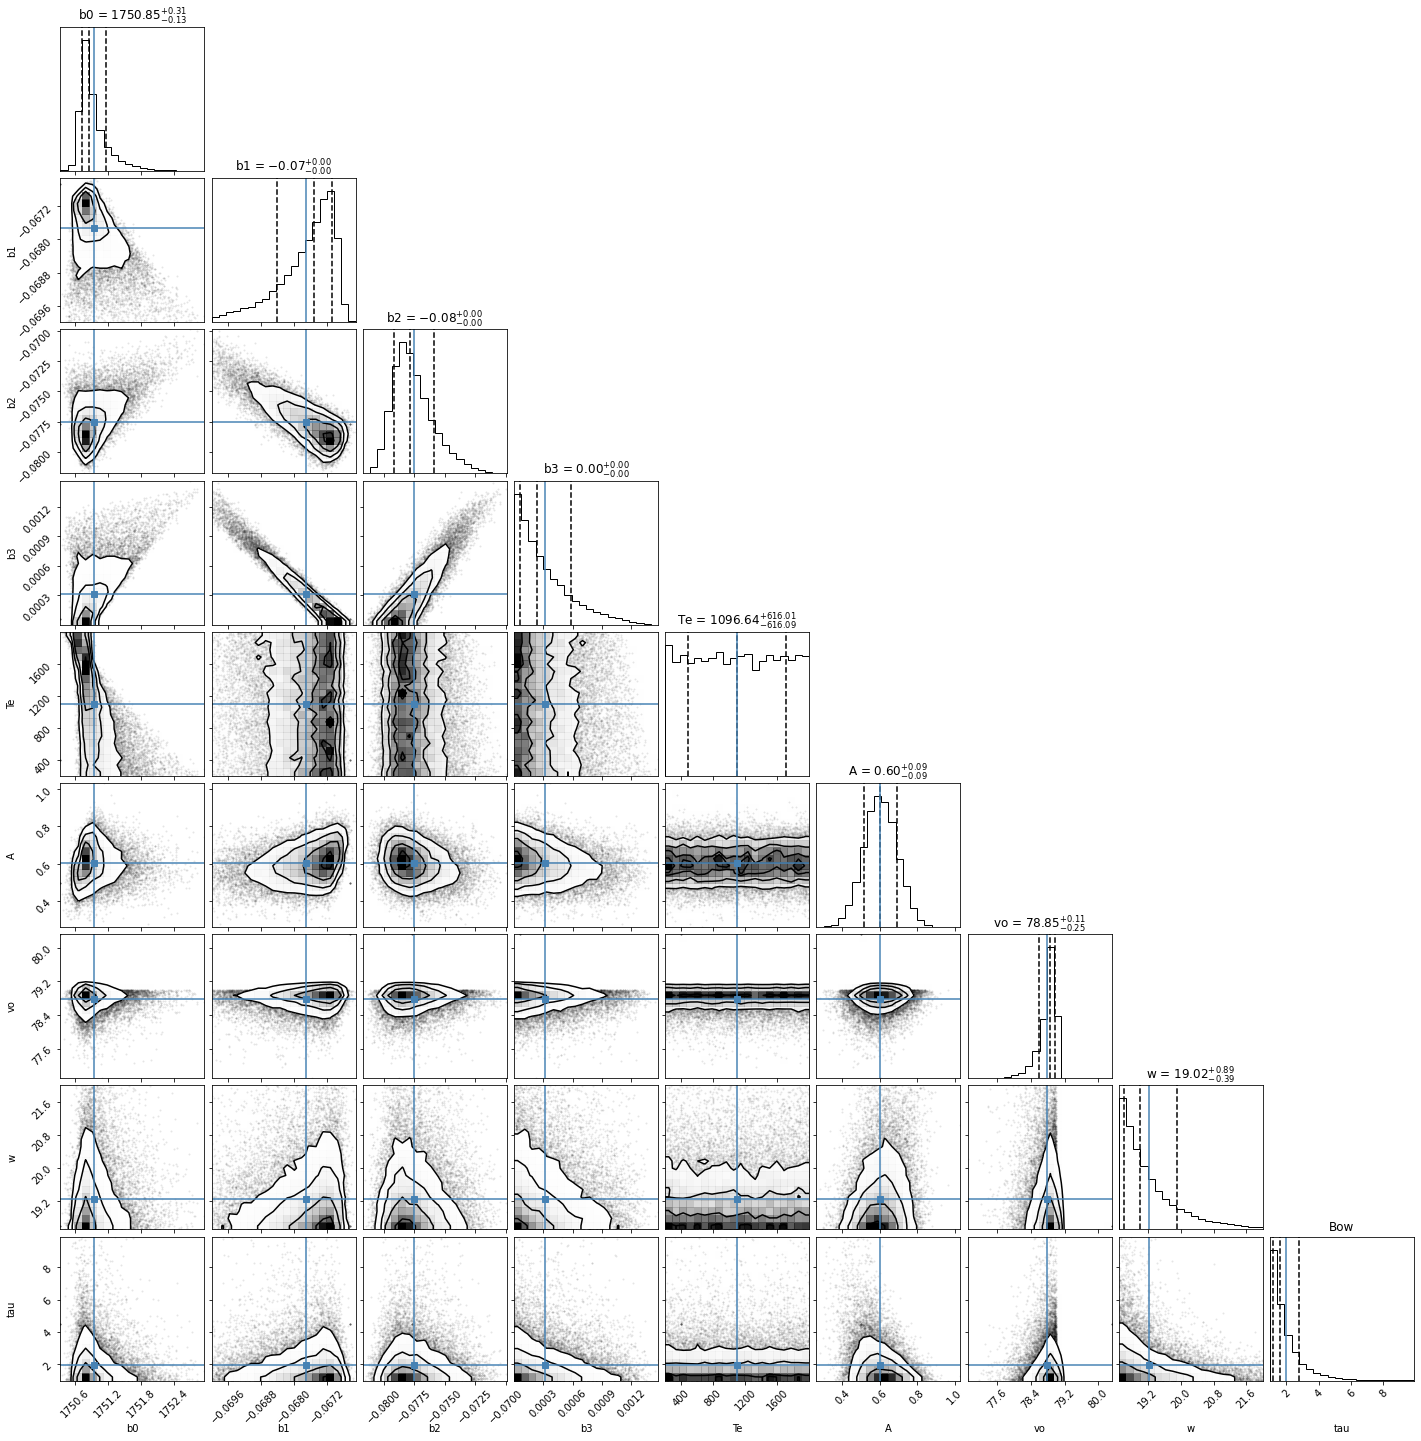

In [ ]:
Nlen=1
names=np.array(['b0','b1','b2','b3','Te','A','vo','w','tau'])
plt.figure()
for i in range(Nlen):
  print(Cons_names[i])
  corner.corner(params,labels=names,quantiles=[0.16, 0.5, 0.84],truths=popt,show_titles=True)
  plt.title(Cons_names[i]) 
plt.show()


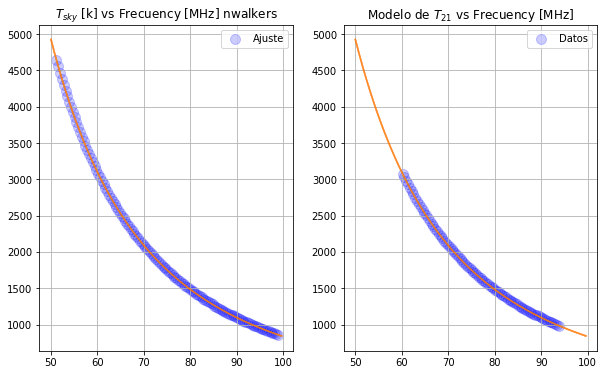

In [ ]:
  ii=0
  fig, axs = plt.subplots(1, 2,figsize=(10, 6))
  axs[0].scatter(x,T_sky(x,*popt),color=Col[ii], label='Ajuste',s=100,alpha=0.2)
  for i in range(int(len(params)/1000)):
    axs[0].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  #axs[0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos')
  axs[0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[1].scatter(x_C,y_C,color='b',alpha=0.2,label='Datos',s=100)
  for i in range(int(len(params)/1000)):
    axs[1].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  axs[1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  for ax in axs.flat:
      ax.legend()
      ax.grid()

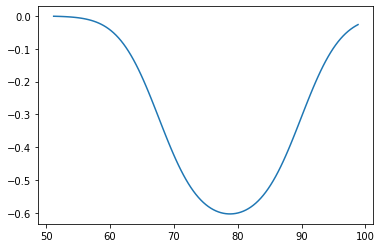

In [ ]:
b0,b1,b2,b3,Te,A,v0,w,tau = popt
plt.plot(x,T_21(x, A,v0,w,tau))

In [ ]:
sampler=samples
var_names=names
emcee_data = az.from_emcee(sampler, var_names=var_names)
emcee_data
az.rhat(emcee_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b0       float64 1.012
    b1       float64 1.011
    b2       float64 1.01
    b3       float64 1.01
    Te       float64 1.01
    A        float64 1.006
    vo       float64 1.007
    w        float64 1.006
    tau      float64 1.006

In [ ]:
def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//10 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=0.13
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      plt.xlabel("Observed Discrepancies")
      plt.xlabel("Simulated Discrepancies")

      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

Rejection rate = 0 %
Bayesian p-value: 0.3374358974358974


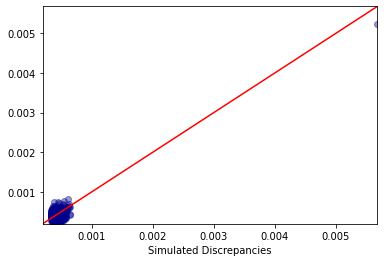

In [ ]:
disc(params,x,y)
#plt.xlim(0,3)
#plt.ylim(0,2)

In [ ]:
params.shape

(19500, 9)

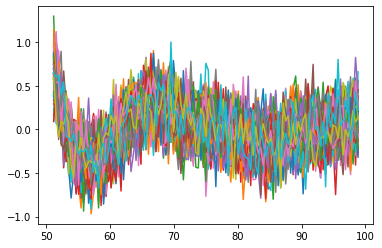

In [ ]:
res=[]
for i in range(100):
    selec=np.random.choice(len(params))
    mu=T_sky(x,*params[selec][0:9])
    sig=0.2
    ysim=np.random.normal(mu,sig)
    res+=[y-ysim]
    plt.plot(x,(y-ysim))

In [ ]:
def discgg(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//10 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=0.13
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
    return discs,disco

Rejection rate = 0 %


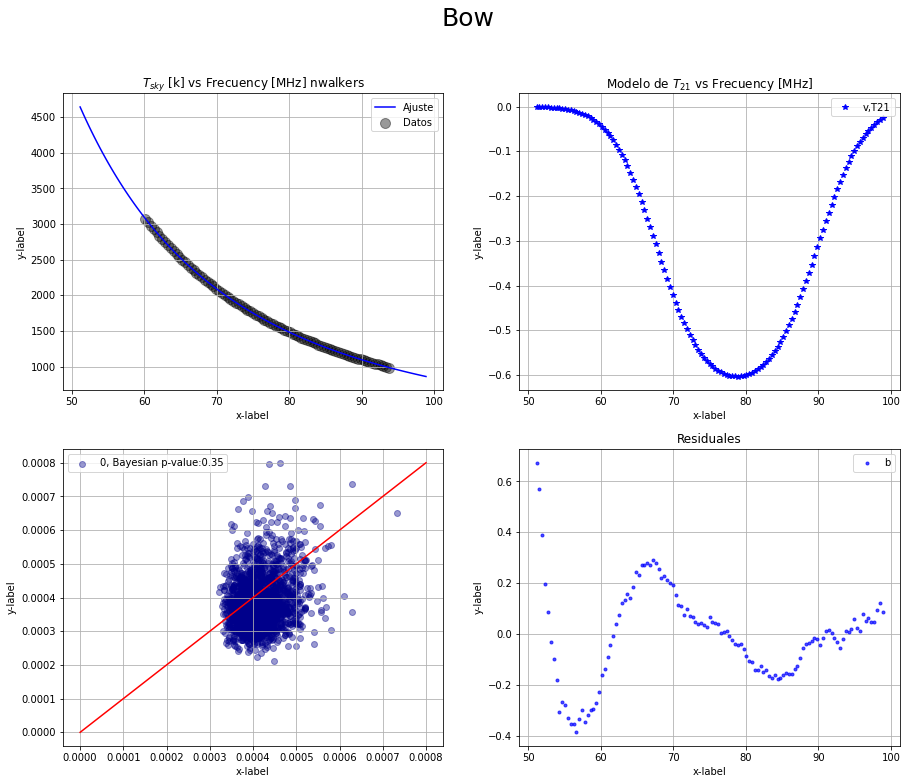

In [ ]:

discs_C,disco_C=discgg(params,x,y)
b0,b1,b2,b3,Te,A,v0,w,tau = np.array(params.mean(axis=0))
for i in range(Nlen):
  fig, axs = plt.subplots(2, 2,figsize=(15, 12))
  fig.suptitle(Cons_names[i],fontsize=25)
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=np.array(params.mean(axis=0))
  axs[0, 0].plot(x,T_sky(x,a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1),color=Col[i], label='Ajuste')
  axs[0, 0].scatter(x_C,y_C,color='black',alpha=0.4,s=100,label='Datos')
  axs[0, 0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[0, 1].plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  axs[0, 1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  axs[1, 0].scatter(disco_C,discs_C,color='darkblue',alpha=0.4,label=str(i)+", Bayesian p-value:"+str(np.round((disco_C<discs_C).sum()*1./len(disco_C),2)))
  dmax=np.max(np.hstack((disco_C,discs_C)))
  dmin=np.min(np.hstack((disco_C,discs_C)))
  ppp=np.linspace(0,dmax,2)
  axs[1, 0].plot(ppp,ppp,c='r')


  axs[1, 1].plot(x,(y-T_sky(x,a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1)),'.',alpha=0.7,color=Col[i],label=str(Col[i]))
  axs[1, 1].set_title('Residuales')

  for ax in axs.flat:
      ax.set(xlabel='x-label', ylabel='y-label')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.legend()
      ax.grid()

# sigma variable

# Others

In [ ]:
Sol=Sol_forz=np.array([1755, -0.08 ,-0.012,0.0052,1100,0.5,78.3,18.9,7.5,0.025]) # profe
Sol=Sol_forz=np.array([1750.88, -0.067 ,-0.078,0.00006,394,0.5,78.3,18.6,4.5,0.2])
#yerr=0.025

In [ ]:
def T_f(v,b0,b1,b2,b3,Te):
  vc=75.0 # frecuancia central (rean) 
  return (b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0)+Te*(1-np.exp(-b3*(v/vc)**-2.0))

def log_like(theta,x,y):
  v=x
  b0,b1,b2,b3,Te,A,v0,w,tau,sigma = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,b0,b1,b2,b3,Te,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
def log_prob(theta, x, y):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x, y)
def log_p(theta):
  b0,b1,b2,b3,Te,A,v0,w,tau,sigma = theta
  if 1700 < b0 < 1800.0 and -0.070 < b1 < -0.007 and  -2.1< b2 < -0.00011 and 0.0000 <b3 < 0.2 and 200 < Te < 2000 and 0.170 < A <8.5 and  76.8< v0 <79.0 and 18.5 <w < 22.0 and 4.0 <tau< 10.0 and 0.02 < sigma <0.92:
  #if 1700 < b0 < 1760.0 and -0.9 < b1 < 0.07 and  -0.9< b2 < 0.11 and -0.10 <b3 < 0.2  and 100 < Te < 2000 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 21.0 and 4.5 <tau< 8.0:
  #if 1740 < b0 < 1760.0 and -0.9 < b1 < 0.07 and  -0.9< b2 < 0.11 and -0.10 <b3 < 0.2 and 100 < Te < 2000 and 0.170 < A <1.9 and  76.8< v0 <82.0 and 10.5 <w < 25.0 and 0.5 <tau< 10.0 and 0.002 < sigma <0.9:
  #if 1740 < b0 < 1760.0 and -0.08 < b1 < -0.0007 and  -2.1< b2 < -0.00011 and 0.00010 <b3 < 0.2 and -2000 < Te < 2500 and 0.170 < A <8.5 and  77.8< v0 <79.0 and 18.5 <w < 20.8 and 4.0 <tau< 10.0 and 0.1 < sigma <0.92:
    return 0.0
  return -np.inf

In [ ]:

def nwalk_b(x,y,Sol,walkers,steps):
  N=len(Sol)  
  pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-4*(np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  pos=pos.T  
  nwalkers, ndim = pos.shape  

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler#discard=N, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [ ]:
steps=80000 #pasos
walkers=500
samples1=nwalk_b(x,y,Sol,walkers,steps)

100%|██████████| 80000/80000 [1:06:34<00:00, 20.03it/s]


In [ ]:
params1=samples1.get_chain(discard=100, thin=2000, flat=True)#parametros
params1.shape
popt=np.array(params1.mean(axis=0))

In [ ]:
params1.shape

(19500, 10)

Bow


<Figure size 432x288 with 0 Axes>

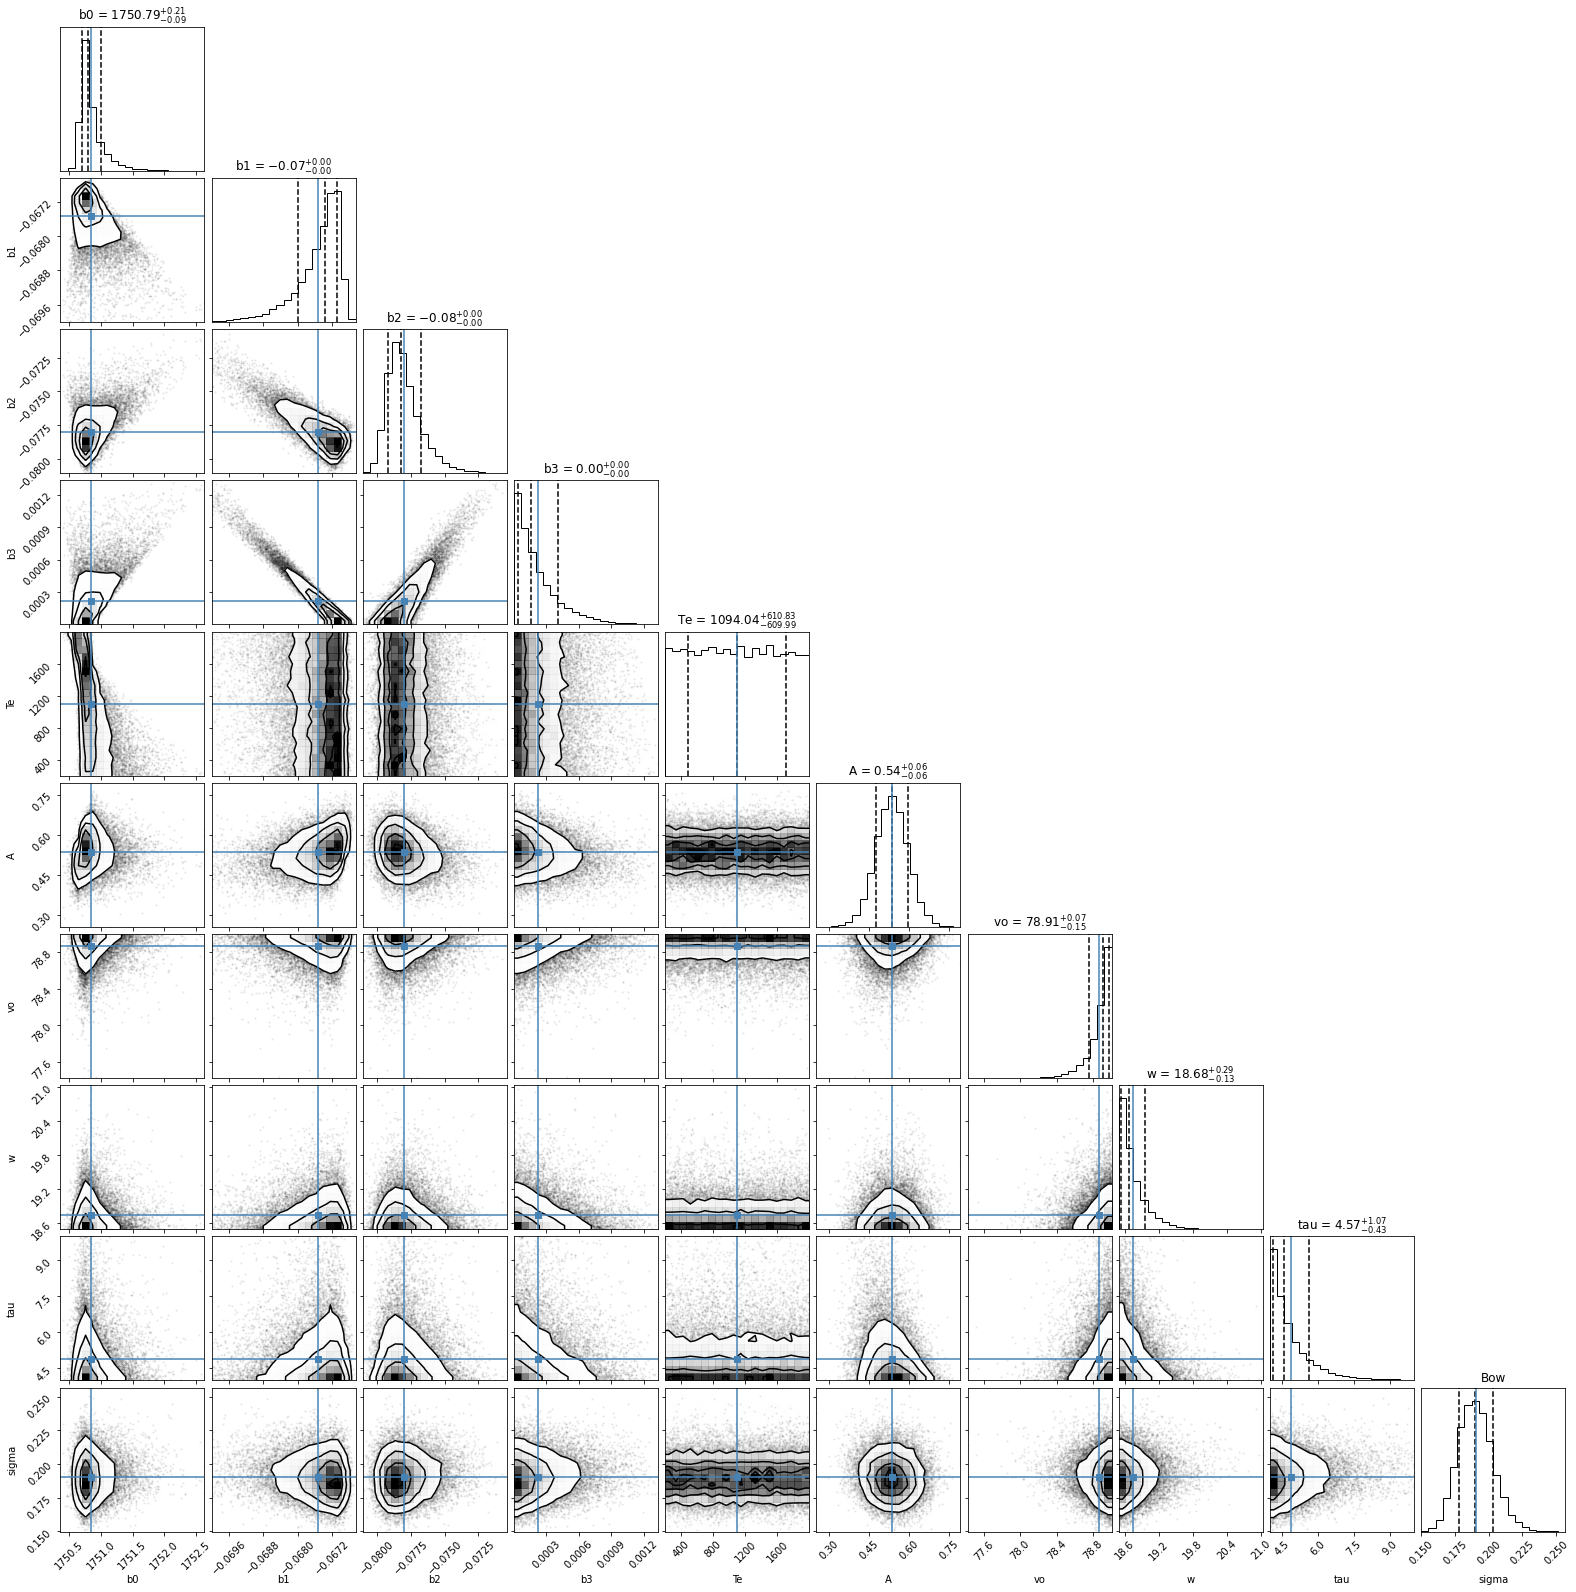

In [ ]:
Nlen=1
names=np.array(['b0','b1','b2','b3','Te','A','vo','w','tau','sigma'])
plt.figure()
for i in range(Nlen):
  print(Cons_names[i])
  corner.corner(params1,labels=names,quantiles=[0.16, 0.5, 0.84],truths=popt,show_titles=True)
  plt.title(Cons_names[i]) 
plt.show()

In [ ]:
sampler=samples1
var_names=names
emcee_data = az.from_emcee(sampler, var_names=var_names)
emcee_data
az.rhat(emcee_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b0       float64 1.011
    b1       float64 1.011
    b2       float64 1.01
    b3       float64 1.011
    Te       float64 1.01
    A        float64 1.006
    vo       float64 1.006
    w        float64 1.006
    tau      float64 1.006
    sigma    float64 1.005

In [ ]:
def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//10 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=abs(np.mean(params[:,9]))
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      plt.xlabel("Observed Discrepancies")
      plt.xlabel("Simulated Discrepancies")

      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

Rejection rate = 0 %
Bayesian p-value: 0.9994871794871795


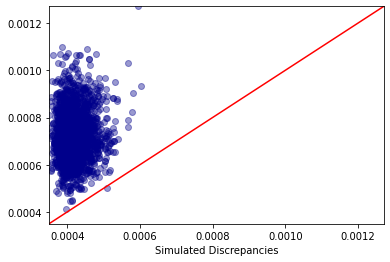

In [ ]:
disc(params1,x,y)

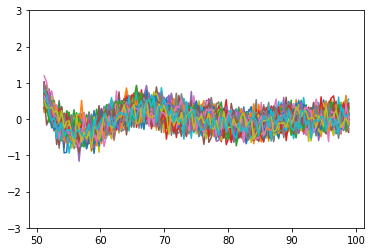

In [ ]:
res=[]
for i in range(100):
    selec=np.random.choice(len(params1))
    mu=T_sky(x,*params1[selec][0:9])
    sig=0.2
    ysim=np.random.normal(mu,sig)
    res+=[y-ysim]
    plt.plot(x,(y-ysim))
    plt.ylim(-3,3)

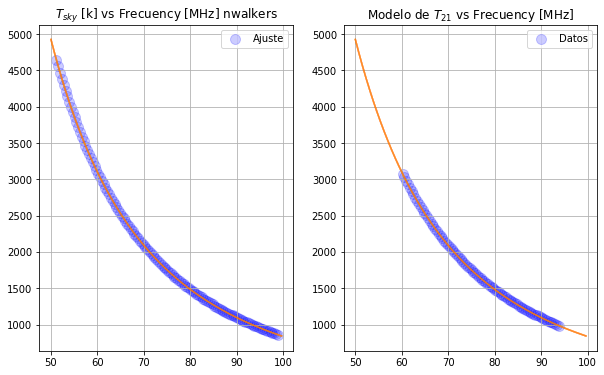

In [ ]:
  params11=params1[:,0:9]
  popt=np.array(params11.mean(axis=0))
  
  ii=0
  fig, axs = plt.subplots(1, 2,figsize=(10, 6))
  axs[0].scatter(x,T_sky(x,*popt),color=Col[ii], label='Ajuste',s=100,alpha=0.2)
  for i in range(int(len(params11)/1000)):
    axs[0].plot(Dat[:,0],T_sky(Dat[:,0],*params11[i]), "C1", alpha=0.1)
  #axs[0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos')
  axs[0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[1].scatter(x_C,y_C,color='b',alpha=0.2,label='Datos',s=100)
  for i in range(int(len(params11)/1000)):
    axs[1].plot(Dat[:,0],T_sky(Dat[:,0],*params11[i]), "C1", alpha=0.1)
  axs[1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  for ax in axs.flat:
      ax.legend()
      ax.grid()

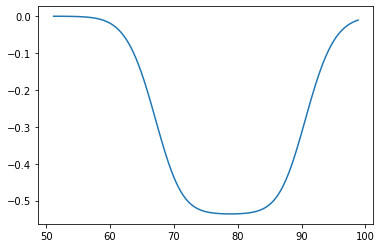

In [ ]:
discs_C,disco_C=discg(params1,x,y)

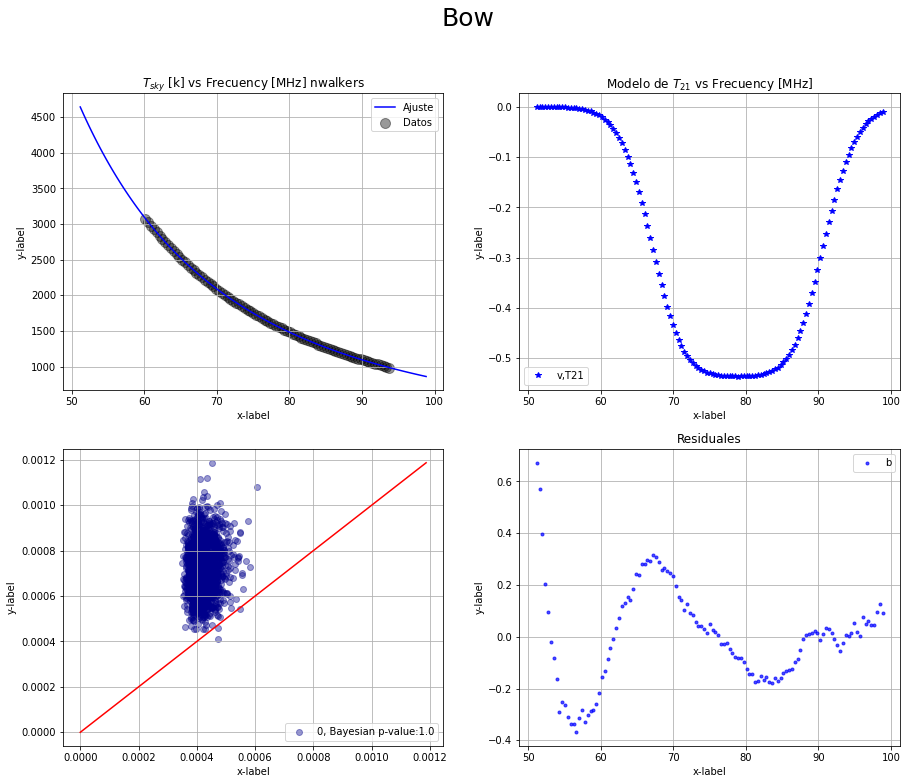

In [ ]:
b0,b1,b2,b3,Te,A,v0,w,tau = np.array(params11.mean(axis=0))
for i in range(Nlen):
  fig, axs = plt.subplots(2, 2,figsize=(15, 12))
  fig.suptitle(Cons_names[i],fontsize=25)
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=np.array(params11.mean(axis=0))
  axs[0, 0].plot(x,T_sky(x,a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1),color=Col[i], label='Ajuste')
  axs[0, 0].scatter(x_C,y_C,color='black',alpha=0.4,s=100,label='Datos')
  axs[0, 0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[0, 1].plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  axs[0, 1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  axs[1, 0].scatter(disco_C,discs_C,color='darkblue',alpha=0.4,label=str(i)+", Bayesian p-value:"+str(np.round((disco_C<discs_C).sum()*1./len(disco_C),2)))
  dmax=np.max(np.hstack((disco_C,discs_C)))
  dmin=np.min(np.hstack((disco_C,discs_C)))
  ppp=np.linspace(0,dmax,2)
  axs[1, 0].plot(ppp,ppp,c='r')


  axs[1, 1].plot(x,(y-T_sky(x,a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1)),'.',alpha=0.7,color=Col[i],label=str(Col[i]))
  axs[1, 1].set_title('Residuales')

  for ax in axs.flat:
      ax.set(xlabel='x-label', ylabel='y-label')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.legend()
      ax.grid()